In [1]:
import supereeg as se
import pandas as pd
import numpy as np
import os
import hypertools as hyp
import plot as plot
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting as ni_plt
import scipy.stats as stats
import scipy.spatial as spatial

In [2]:
fig_dir = '../../paper/figs/source/density'

In [3]:
ram_data_dir = '../../data/ram'
pyfr_data_dir = '../../data/pyfr'

In [4]:
r = 20

In [5]:
fig_count = 0

# PyFR analysis

In [6]:
pyFR_df = pd.read_csv(os.path.join(pyfr_data_dir, 'pyfr.csv'), index_col=0)

## Compile pyfr locations and across correlations

In [7]:
pyfr_locs = plot.compile_df_locs(pyFR_df['R'])
corr_pyfr_locs = np.atleast_2d(pyFR_df['across'])

## Find locations within 10 

In [8]:
pyFR_df['Density'] = plot.density_within_r(pyfr_locs, r)

In [9]:
pyFR_df.head()

,across,within,Subject,R,Sample rate,Samples,Thresholded electrodes,Sessions,Number thresholded,Total time (h),Average session length (hrs),Total electrodes,Proportion thresholded,Average session length (h),Density
0,0.844742,0.639768,31,[-63.64 -21.93 5.37],250.0,3465000,10,7.0,42,3.850,0.550,52,0.808,0.550,0.026631
1,0.861268,0.640264,8,[-48.48 38.4 17.26],250.0,1549237,121,2.0,2,1.721,0.860,123,0.016,0.860,0.028071
2,0.665390,0.519857,13,[ 49.49 -34.7 35.17],250.0,2454000,44,4.0,79,2.727,0.682,123,0.642,0.682,0.015355
3,0.641038,0.445575,52,[ 65.66 -67.29 25.83],250.0,3600000,82,2.0,16,4.000,2.000,98,0.163,2.000,0.011756
4,0.764453,0.504416,25,[-36.36 -1.81 59.76],250.0,447750,98,1.0,2,0.498,0.498,100,0.020,0.498,0.013916


## plot density by location

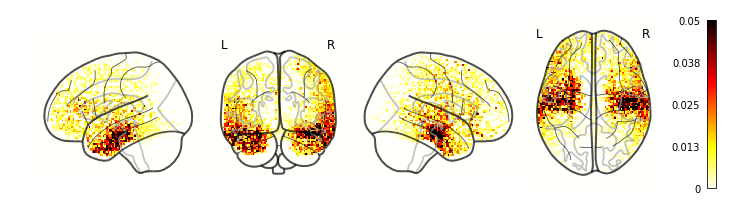

In [10]:
plot.interp_density(pyfr_locs, np.atleast_2d(plot.density_within_r(pyfr_locs, 20)), width=2, vox_size=2, outfile=None)

## correlate density by correlation across subjects

In [11]:
rstat = stats.pearsonr(pyFR_df['Density'], plot.r2z(pyFR_df['across']))
print(rstat)

(-0.07076363844346745, 4.8109588198027475e-06)


## correlate density by correlation within subjects

In [12]:
rstat = stats.pearsonr(pyFR_df['Density'], plot.r2z(pyFR_df['within']))
print(rstat)

(0.02525301865961722, 0.10307887101817848)


## plot density by voxel in 4mm MNI brain

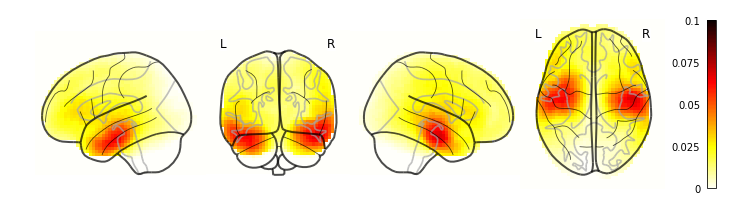

In [13]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.density_by_voxel_plot(pyfr_locs, r=r, vox_size=4, outfile=outfile)

In [14]:
density_by_vox_pyfr = plot.density_by_voxel(pyfr_locs, r=r, vox_size=4)

# RAM

In [15]:
RAM_df = pd.read_csv(os.path.join(ram_data_dir, 'ram.csv'), index_col=0)

In [16]:
all_locs = plot.compile_df_locs(RAM_df['R'])
corr_all_locs = np.atleast_2d(RAM_df['W_a_w'])

## Find locations within 10 

In [17]:
RAM_df['Density'] = plot.density_within_r(all_locs, r)

## correlate density by correlation across subjects

In [18]:
rstat = stats.pearsonr(RAM_df['Density'], plot.r2z(RAM_df['W_a_w']))
print(rstat)

(-0.18147982308277585, 8.537160304258218e-25)


## plot density by voxel in 4mm MNI brain

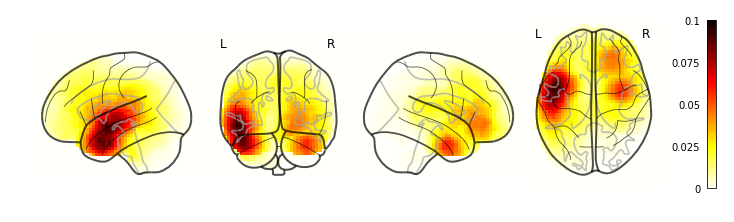

In [19]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.density_by_voxel_plot(all_locs, r=r, vox_size=4, outfile=outfile)

In [20]:
density_by_vox_all = plot.density_by_voxel(all_locs, r=r, vox_size=4)

## scatter plot of correspondence between density by voxel for each dataset 

In [21]:
density_locs_df = pd.DataFrame()
density_locs_df['RAM'] = density_by_vox_all
density_locs_df['PyFR'] = density_by_vox_pyfr
density_locs_df.dropna(inplace=True)

(0.5559080936024179, 0.0)


<Figure size 1332x1332 with 0 Axes>

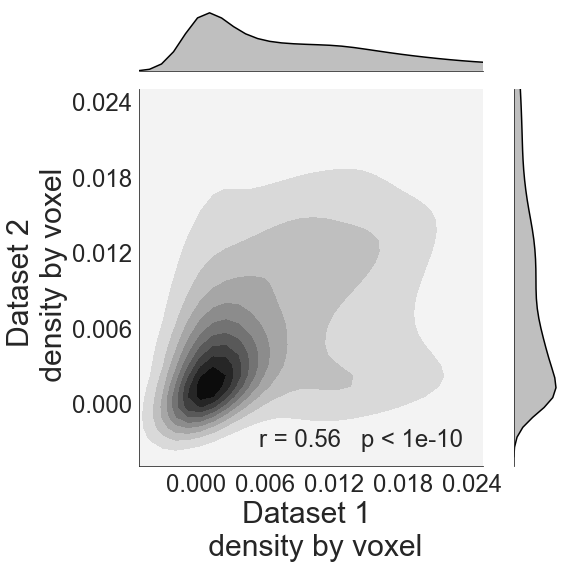

In [22]:
fig_count +=1
outfile = os.path.join(fig_dir, str(fig_count) + '.pdf')
plot.plot_2d_hist(density_locs_df, outfile=outfile)
